# Alpaca-Q/A

This notebook contains minimal code for running within a UI created by Pynecone [Alpaca](https://github.com/tloen/alpaca-lora/) for demonstration purposes. Please check the repo for more details.

## NoteS
- Remember this 7-billion fined-tuned model on data generated by GPT 3, it's small model compared to chat gpt, running is small gpu, it will not provide the best answer, and it will take time to load - it was created for education purpose only - https://github.com/tloen/alpaca-lora/ 
- Building the app will take around 6 min or may be more depends on your connection (download rate, that google gives you)
- it's slow compared to chat-gpt, but functional, it's just slow
- follow up by having `logs.txt` opened, so you can understand what's going on, refresh `logs.txt` to see updates, by reopening it
- Web app url is kind of buggy, you might need to refresh
- honstly it's hard to keep tracking of what's going, just run all the cells and refresh the url or rerun the `APP-Cell` 
- ignore warnings
- better test within colab cells, you might rarely need to rerun the app-cell
- these lines indicates that your app is ready to take off 
<!-- ```bash
wait  - compiling 
event - compiled client and server succesfully in xxxx ms 
``` -->

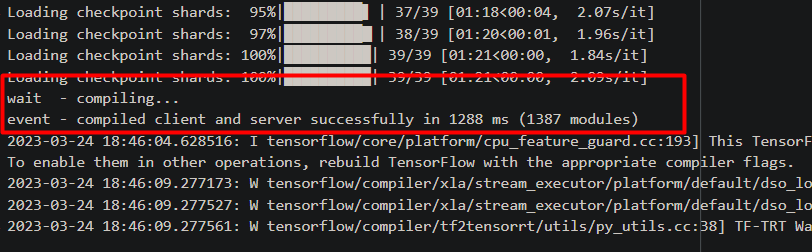

In [ ]:
#@title Keep this tab alive to prevent Colab from disconnecting you { display-mode: "form" }

#@markdown Press play on the music player that will appear below:
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

In [9]:
#@title  dependencies  
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

clear_output()
!pip install -q bitsandbytes

# alpaca training dataset - training LLAMA is byond being done on Tesla T4, well at least i don't know how to do quantized training yet
!pip install -q datasets loralib sentencepiece 
!pip install -q git+https://github.com/zphang/transformers@c3dc391 
#Peft, is a method to load fine-tuned models -> https://huggingface.co/blog/peft
!pip install -q git+https://github.com/huggingface/peft.git

!pip -q install pynecone
!npm -q install localtunnel
clear_output()

In [2]:
#@title build & Initialize  - terminate instance for building errors
# initialize and build 
!pc init
# colab runs one cell at a time, running pc app should be a background process
!pc run &>/content/logs.txt & 

# the following commands should be run in the background 
# accessing the output for these cells is important and should be coded
!npx localtunnel --port 8000 &>/content/backend.txt &
!npx localtunnel --port 3000 &>/content/frontend.txt &

[16:32:01] Installing bun...                                        ]8;id=679231;file:///usr/local/lib/python3.9/dist-packages/pynecone/utils.py\utils.py]8;;\:]8;id=404654;file:///usr/local/lib/python3.9/dist-packages/pynecone/utils.py#440\440]8;;\
######################################################################## 100.0%
⠴ Initializing contentbun was installed successfully to ~/.bun/bin/bun 

⠦ Initializing contentAdded "~/.bun/bin" to $PATH in "~/.bashrc" 

To get started, run: 

 source /root/.bashrc 
  bun --help 
[16:32:03] Initializing the web directory.                          ]8;id=709969;file:///usr/local/lib/python3.9/dist-packages/pynecone/utils.py\utils.py]8;;\:]8;id=293690;file:///usr/local/lib/python3.9/dist-packages/pynecone/utils.py#421\421]8;;\
           Initializing the app directory.                          ]8;id=931809;file:///usr/local/lib/python3.9/dist-packages/pynecone/utils.py\utils.py]8;;\:]8;id=719468;file:///usr/local/lib/python3

## Warning 
you should have logs.txt opened to check how is pynecone performs in the background and also for debugging

In [3]:
#@title Allocating ports 

#* wait for logs to be written, to fetch urls
import time
time.sleep(8)

with open('frontend.txt') as f:
  frontlines = f.readlines()  
front_url = str(frontlines[1].split()[-1])
# front_url

In [12]:
#@title  main app
%%writefile /content/content/content.py

import warnings
warnings.filterwarnings("ignore")

####################################MODEL#####################################################

def generate_prompt(instruction: str, input_ctxt: str = None) -> str:
    if input_ctxt:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input_ctxt}

### Response:"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:"""

import torch
from transformers import LLaMATokenizer, LLaMAForCausalLM, GenerationConfig

tokenizer = LLaMATokenizer.from_pretrained("chainyo/alpaca-lora-7b")
model = LLaMAForCausalLM.from_pretrained(
    "chainyo/alpaca-lora-7b",
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

model.eval()
if torch.__version__ >= "2":
    model = torch.compile(model)


def response(instruction, generation_config, input_ctxt=None):
  prompt = generate_prompt(instruction, input_ctxt)
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids
  input_ids = input_ids.to(model.device)

  with torch.no_grad():
      outputs = model.generate(
          input_ids=input_ids,
          generation_config=generation_config,
          return_dict_in_generate=True,
          output_scores=True,
      )

  answer = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
  return answer.split("### Response:")[1].strip()


####################################MODEL#####################################################


import pynecone as pc


class alpaca_chat(pc.State):
    _question: str = ""
    _answer: str = ""
    input = ""

    # ** check box for output
    code: bool = False
    code_lang: str = "python"
    input_enable: str = False

    # ** chech for answer
    thinking = False

    # * generation parameters
    temp: float = 2.0
    num_words: int = 45
    #################### UI Changing params #############################
    #TODO : connect them to the ui 
    
    #################### Text Area ###############################
    def set_question(self, question):
        self._question = question

    @pc.var
    def get_question(self):
        return self._question

    ##################### button ################################

    def process_answer(self):
        self.thinking = True

    def get_answer(self):
        #TODO : Change your model 
        #TODO : handle inputs for instsructions 
        generation_config = GenerationConfig(
          temperature = float(float(self.temp) / 10),
          top_p=0.75,
          top_k=40,
          num_beams=4,
          max_new_tokens= int(self.num_words))

        self._answer = response(self._question, generation_config)
        ## #####################
        self.thinking = False

    @pc.var
    def view_answer(self):
        return self._answer

    ##################### generation parameters ##################

    def code_output(self):
        self.code = not (self.code)


def index():
    return pc.box(
        pc.vstack(
            # * Title
            pc.center(
                pc.heading(
                    "Alpaca-Q/A",
                    font_size="3.5em",
                    _hover={"cursor": "pointer"},
                ),
                padding_bottom="2em",
                width="75%",
                #padding_right="2em",
            ),
            pc.hstack(
                pc.vstack(
                    # * Question spot
                    pc.heading("instruction", font_size="1.5em", align_items="left"),
                    pc.text_area(
                        placeholder="Ask Alpaca",
                        on_blur=alpaca_chat.set_question,
                        width="100%",
                        background="white",
                    ),
                    pc.divider(),
                    pc.cond(
                        alpaca_chat.input_enable,
                        c1=pc.vstack(
                            pc.heading("Input", font_size="1.5em"),
                            pc.text_area(
                                placeholder="input for Question",
                                on_blur=alpaca_chat.set_input,
                                background="white",
                            ),
                            width="100%",
                        ),
                    ),
                    pc.divider(),
                    # * waiting for answer
                    pc.cond(
                        alpaca_chat.thinking,
                        pc.vstack(
                            pc.text("Alpaca is thinking "),
                            pc.progress(is_indeterminate=True, width="75%"),
                        ),
                        # pc.text("Alapaca is done "),
                    ),
                    # * Answer spot
                    pc.cond(
                        alpaca_chat.code,
                        c1=pc.vstack(
                            pc.text("you : " + alpaca_chat.get_question,width="100%",background="white",),
                            pc.text("Alpaca : ",width="100%",background="white",),
                            pc.code_block(alpaca_chat.view_answer,width="100%",language=alpaca_chat.code_lang,),
                            width="100%",background="white",
                        ),
                        c2=pc.vstack(
                            pc.text("you : " + alpaca_chat.get_question, width="100%", background="white"),
                            pc.text("Alpaca : " + alpaca_chat.view_answer, width="100%", background="white"), width="100%", background="white"),
                      ),
                    pc.center(  # * chat button
                        pc.button(
                            "Ask Alpaca",
                            width="100%",
                            on_click=[
                                alpaca_chat.process_answer,
                                alpaca_chat.get_answer,
                            ],
                            background="gray",
                        ),
                    ),
                    pc.accordion(
                        pc.accordion_item(
                            pc.accordion_button(
                                pc.heading("Generation Settings"),
                                pc.accordion_icon(),
                                reduce_motion=True,
                            ),
                            pc.accordion_panel(
                                pc.center(
                                    pc.vstack(
                                        # * unique ability
                                        pc.hstack(
                                            pc.center(
                                                pc.tooltip(
                                                    pc.text(
                                                        f"Tempreture ", font_size=20
                                                    ),
                                                    label="This indicates unique-ability of genereation, set high for relatively close generation",
                                                ),
                                                pc.spacer(),
                                                pc.slider(
                                                    default_value=2,
                                                    on_change=alpaca_chat.set_temp,
                                                    min_=1,
                                                    max_=10,
                                                    width="50%",
                                                ),
                                                width="100%",
                                            ),
                                            width="100%",
                                        ),
                                        # * code output
                                        pc.hstack(
                                            pc.center(
                                                pc.tooltip(
                                                    pc.text(
                                                        "Code Output", font_size=20
                                                    ),
                                                    label="enable to handle generated code correctly",
                                                ),
                                                pc.spacer(),
                                                pc.switch(
                                                    on_change=alpaca_chat.set_code
                                                ),
                                                width="100%",
                                            ),
                                            width="100%",
                                        ),
                                        # * Input enable for instruction like summarize:
                                        pc.hstack(
                                            pc.center(
                                                pc.tooltip(
                                                    pc.text(
                                                        "Instruction's input - Not Working yet",
                                                        font_size=20,
                                                    ),
                                                    label="Enable when your task includes inputs, ex : Summarize ",
                                                ),
                                                pc.spacer(),
                                                pc.switch(
                                                    on_change=alpaca_chat.set_input_enable
                                                ),
                                                width="100%",
                                            ),
                                            width="100%",
                                        ),
                                        # * number of generated words
                                        pc.hstack(
                                            pc.center(
                                                pc.tooltip(
                                                    pc.text(
                                                        "Max number of tokens",
                                                        font_size=20,
                                                    ),
                                                    label="Max Number of generated words",
                                                ),
                                                pc.spacer(),
                                                pc.number_input(
                                                    defaultValue=64,
                                                    on_change=alpaca_chat.set_num_words,
                                                    width="50%",
                                                    background="white",
                                                    max_ = 250,
                                                    min_ = 10,
                                                ),
                                                width="100%",
                                            ),
                                            width="100%",
                                        ),
                                        # * language output horizontal stack
                                        pc.hstack(
                                            pc.center(
                                                pc.tooltip(
                                                    pc.text(
                                                        "code language", font_size=20
                                                    ),
                                                    label="Write the type of language",
                                                ),
                                                pc.spacer(),
                                                pc.input(
                                                    defaultValue="python",
                                                    on_blur=alpaca_chat.set_code_lang,
                                                    width="50%",
                                                    background="white",
                                                ),
                                                # pc.switch(on_change=alpaca_chat.set_code),
                                                width="100%",
                                            ),
                                            width="100%",
                                        ),
                                        pc.alert(
                                            pc.alert_icon(),
                                            pc.alert_title(
                                                "Refresh if it took longer than intended, don't worry, your answer'll be there"
                                            ),
                                            status="warning",
                                        ),
                                    ),
                                    width="100%",
                                ),
                            ),
                        ),
                        width="100%",
                    ),
                    width="100%",
                    padding_bottom="4em",
                ),
                width="80%",
                align_items="bottom",
            ),
            width="100%",
            height="100%",
            padding_top="2em",
            # background="radial-gradient(circle at 22% 11%,rgba(62, 180, 137,.20),hsla(0,0%,100%,0) 19%),radial-gradient(circle at 82% 25%,rgba(33,150,243,.18),hsla(0,0%,100%,0) 35%),radial-gradient(circle at 25% 61%,rgba(250, 128, 114, .28),hsla(0,0%,100%,0) 55%)",
            # background = 'white',
        ),
        width="100%",
        height="100%",
        padding_top="2em",
        background="radial-gradient(circle at 22% 11%,rgba(62, 180, 137,.20),hsla(0,0%,100%,0) 19%),radial-gradient(circle at 82% 25%,rgba(33,150,243,.18),hsla(0,0%,100%,0) 35%),radial-gradient(circle at 25% 61%,rgba(250, 128, 114, .28),hsla(0,0%,100%,0) 55%)",
    )


app = pc.App(state=alpaca_chat)
app.add_page(index)
app.compile()


Overwriting /content/content/content.py


In [6]:
#@title recorrect configuations
%%writefile /content/pcconfig.py

import pynecone as pc

with open('backend.txt') as f:
  lines = f.readlines()
back_url = str(lines[1].split()[-1])

config = pc.Config(
    app_name="content",
    api_url=back_url, # connecting the backend
    bun_path="/content/.bun/bin/bun", # recorrect bun path
    db_url="sqlite:///pynecone.db",
    telemetry_enabled=False,
    port = 8000
)

Overwriting /content/pcconfig.py


## Don't forget to rerun

In [14]:
print("click here to view app", front_url)

click here to view app https://afraid-masks-sip-35-247-82-41.loca.lt


## Just CLick to Continue

In [16]:
#@title app-cell, might take few seconds
import ipywidgets as widgets
from IPython.display import IFrame
IFrame(src=front_url, width='100%', height='600px')